In [ ]:
# Complete pipeline: training 36 models (3 resource types × 4 regions × 3 models) and visualizing forecasts

#  1: Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

sns.set(style='whitegrid')

#  2: Load and prepare data
#  2: Load & Inspect Data
df = pd.read_csv('D:\infosysspringboard projects\project1-1stmilestine\AZURE_BACKEND_TEAM-B\data\processed\cleaned_merged.csv', parse_dates=['date'])
print(df.shape, df.columns.tolist())
df.head()

# # Assuming 'df' is your original dataset with columns:
# # ['date', 'region', 'resource_type', 'usage_cpu', 'usage_storage', 'users_active', 'economic_index', 'cloud_market_demand', 'holiday']

# Convert date to datetime and sort data
df['date'] = pd.to_datetime(df['date'])
df.sort_values(['region', 'resource_type', 'date'], inplace=True)

#  3: Helper function to compute metrics
def compute_metrics(true_vals, preds):
    rmse = np.sqrt(mean_squared_error(true_vals, preds))
    mae = mean_absolute_error(true_vals, preds)
    mape = np.mean(np.abs((true_vals - preds) / true_vals)) * 100
    return rmse, mae, mape



(1080, 9) ['date', 'region', 'resource_type', 'usage_cpu', 'usage_storage', 'users_active', 'economic_index', 'cloud_market_demand', 'holiday']


In [2]:
# Cell 3 (updated for Approach 3: Distinct model training by resource type and region)
# No aggregation across resource types; keep data distinct for combinations of region & resource_type

resource_region_daily = (
    df
    .groupby(['region', 'resource_type', 'date'])
    .agg(
        usage_cpu=('usage_cpu', 'mean'),
        usage_storage=('usage_storage', 'mean'),
        users_active=('users_active', 'sum'),
        economic_index=('economic_index', 'first'),
        cloud_market_demand=('cloud_market_demand', 'first'),
        holiday=('holiday', 'max')
    )
    .sort_index()
    .reset_index()
)

print(resource_region_daily.shape)
resource_region_daily.head()


(1080, 9)


,region,resource_type,date,usage_cpu,usage_storage,users_active,economic_index,cloud_market_demand,holiday
0,East US,Container,2023-01-01,70.0,621.0,414,104.97,0.99,1
1,East US,Container,2023-01-02,86.0,1146.0,220,106.48,1.15,0
2,East US,Container,2023-01-03,57.0,1985.0,414,97.66,0.98,0
3,East US,Container,2023-01-04,57.0,1279.0,232,115.79,1.08,0
4,East US,Container,2023-01-05,85.0,1024.0,359,95.31,1.05,0


In [3]:
# Cell 4 (updated for Approach 3: Distinct timeseries by region & resource_type)

region_resource_dfs = {}

# Group by both region and resource_type, then create separate daily timeseries for each group
for (region, resource_type), grp in resource_region_daily.groupby(['region', 'resource_type']):
    ts = grp.set_index('date').drop(['region', 'resource_type'], axis=1).asfreq('D')
    region_resource_dfs[(region, resource_type)] = ts
    print(f"{region} - {resource_type}: {ts.shape}")


East US - Container: (90, 6)
East US - Storage: (90, 6)
East US - VM: (90, 6)
North Europe - Container: (90, 6)
North Europe - Storage: (90, 6)
North Europe - VM: (90, 6)
Southeast Asia - Container: (90, 6)
Southeast Asia - Storage: (90, 6)
Southeast Asia - VM: (90, 6)
West US - Container: (90, 6)
West US - Storage: (90, 6)
West US - VM: (90, 6)


In [4]:
# Cell 5 (updated for Approach 3): Train/Test Split Function for each region-resource time series

def train_test_split_ts(ts, train_frac=0.8):
    """
    Splits the input time series DataFrame or Series into train and test sets
    chronologically based on train_frac ratio.
    
    Parameters:
    ts : pandas Series or DataFrame, indexed by date
    train_frac : float, fraction of data used for training (default 0.8)
    
    Returns:
    tuple (train_ts, test_ts)
    """
    n = len(ts)
    split = int(train_frac * n)
    train_ts = ts.iloc[:split]
    test_ts = ts.iloc[split:]
    return train_ts, test_ts

# Usage will be applied per distinct (region, resource_type) time series in the pipeline


In [5]:
# Cell 6 (updated for Approach 3): ARIMA for each (region, resource_type) combination
from statsmodels.tsa.arima.model import ARIMA

arima_results = {}

for (region, resource_type), ts in region_resource_dfs.items():
    usage = ts['usage_cpu'].dropna()
    split = int(0.8 * len(usage))
    
    # Optional special treatment for specific combos can be added here
    # For simplicity, use standard ARIMA(5,1,0) for all
    
    train_ts = usage.iloc[:split]
    test_ts = usage.iloc[split:]
    
    model = ARIMA(train_ts, order=(5, 1, 0)).fit()
    arima_preds = model.forecast(steps=len(test_ts))
    
    actual = test_ts.values
    
    arima_rmse, arima_mae, arima_mape = compute_metrics(actual, arima_preds)
    arima_results[(region, resource_type)] = (model, arima_rmse, arima_mae, arima_mape, test_ts, arima_preds)
    print(f"ARIMA [{region} - {resource_type}] → RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.1f}%")


ARIMA [East US - Container] → RMSE: 14.14, MAE: 12.34, MAPE: 18.7%
ARIMA [East US - Storage] → RMSE: 16.94, MAE: 15.00, MAPE: 19.3%
ARIMA [East US - VM] → RMSE: 13.65, MAE: 10.68, MAPE: 15.3%
ARIMA [North Europe - Container] → RMSE: 14.95, MAE: 12.36, MAPE: 18.3%
ARIMA [North Europe - Storage] → RMSE: 20.84, MAE: 18.41, MAPE: 22.4%
ARIMA [North Europe - VM] → RMSE: 20.20, MAE: 16.25, MAPE: 26.4%
ARIMA [Southeast Asia - Container] → RMSE: 12.30, MAE: 9.73, MAPE: 15.0%
ARIMA [Southeast Asia - Storage] → RMSE: 15.19, MAE: 13.52, MAPE: 18.9%
ARIMA [Southeast Asia - VM] → RMSE: 14.83, MAE: 12.02, MAPE: 16.0%
ARIMA [West US - Container] → RMSE: 24.08, MAE: 20.20, MAPE: 33.0%
ARIMA [West US - Storage] → RMSE: 17.64, MAE: 14.93, MAPE: 22.6%
ARIMA [West US - VM] → RMSE: 17.87, MAE: 13.83, MAPE: 21.3%


In [6]:
# Cell 7 (updated for Approach 3): XGBoost on each (region, resource_type) time series

xgb_results = {}

for (region, resource_type), ts in region_resource_dfs.items():
    df2 = ts.copy()
    
    # Feature engineering: add lag and rolling statistics + time features
    df2['lag1'] = df2['usage_cpu'].shift(1)
    df2['lag7'] = df2['usage_cpu'].shift(7)
    df2['roll7_mean'] = df2['usage_cpu'].rolling(7).mean()
    df2['dow'] = df2.index.dayofweek
    df2.dropna(inplace=True)
    
    features = ['lag1', 'lag7', 'roll7_mean', 'users_active', 'economic_index', 'dow', 'holiday']
    X, y = df2[features], df2['usage_cpu']
    
    split = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        early_stopping_rounds=10
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    mape = np.mean(np.abs((y_test - preds) / y_test)) * 100
    
    xgb_results[(region, resource_type)] = (model, rmse, mae, mape, X_test.index, y_test, preds)
    print(f"XGB [{region} - {resource_type}] → RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")


XGB [East US - Container] → RMSE: 14.51, MAE: 12.50, MAPE: 18.59%
XGB [East US - Storage] → RMSE: 13.86, MAE: 10.56, MAPE: 15.35%
XGB [East US - VM] → RMSE: 12.99, MAE: 10.02, MAPE: 14.51%
XGB [North Europe - Container] → RMSE: 12.58, MAE: 10.63, MAPE: 15.63%
XGB [North Europe - Storage] → RMSE: 15.49, MAE: 13.98, MAPE: 18.53%
XGB [North Europe - VM] → RMSE: 18.23, MAE: 17.20, MAPE: 24.82%
XGB [Southeast Asia - Container] → RMSE: 12.29, MAE: 9.55, MAPE: 14.84%
XGB [Southeast Asia - Storage] → RMSE: 14.37, MAE: 11.49, MAPE: 15.46%
XGB [Southeast Asia - VM] → RMSE: 13.87, MAE: 12.00, MAPE: 16.24%
XGB [West US - Container] → RMSE: 14.45, MAE: 11.93, MAPE: 17.54%
XGB [West US - Storage] → RMSE: 14.43, MAE: 11.49, MAPE: 16.06%
XGB [West US - VM] → RMSE: 11.56, MAE: 9.72, MAPE: 13.58%


In [7]:
# Cell 8 (updated for Approach 3): Univariate LSTM per (region, resource_type)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

lstm_results = {}
n_steps = 30

for (region, resource_type), ts in region_resource_dfs.items():
    seq = ts[['usage_cpu']].dropna().values
    
    if len(seq) < n_steps + 1:
        print(f"Skipping LSTM for {region} - {resource_type} due to insufficient data.")
        continue
    
    scaler = MinMaxScaler()
    seq_scaled = scaler.fit_transform(seq)
    
    Xs, ys = [], []
    for i in range(n_steps, len(seq_scaled)):
        Xs.append(seq_scaled[i-n_steps:i, 0])
        ys.append(seq_scaled[i, 0])
    Xs, ys = np.array(Xs), np.array(ys)
    
    split_l = int(0.8 * len(Xs))
    X_train_l, X_test_l = Xs[:split_l], Xs[split_l:]
    y_train_l, y_test_l = ys[:split_l], ys[split_l:]
    
    X_train_l = X_train_l.reshape((len(X_train_l), n_steps, 1))
    X_test_l  = X_test_l.reshape((len(X_test_l), n_steps, 1))
    
    lstm_model = Sequential([
        LSTM(50, input_shape=(n_steps, 1)),
        Dropout(0.2),
        Dense(1)
    ])
    
    lstm_model.compile(optimizer='adam', loss='mse')
    
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    lstm_model.fit(
        X_train_l, y_train_l,
        epochs=50,
        batch_size=16,
        validation_split=0.2,
        callbacks=[es],
        verbose=0
    )
    
    preds_scaled = lstm_model.predict(X_test_l, verbose=0).flatten()
    y_test_inv = scaler.inverse_transform(y_test_l.reshape(-1,1)).flatten()
    preds_inv  = scaler.inverse_transform(preds_scaled.reshape(-1,1)).flatten()
    
    lstm_rmse, lstm_mae, lstm_mape = compute_metrics(y_test_inv, preds_inv)
    
    lstm_results[(region, resource_type)] = (lstm_model, scaler, lstm_rmse, lstm_mae, lstm_mape, X_test_l, y_test_inv, preds_inv)
    
    print(f"LSTM [{region} - {resource_type}] → RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}, MAPE: {lstm_mape:.1f}%")


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM [East US - Container] → RMSE: 14.46, MAE: 12.11, MAPE: 17.7%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM [East US - Storage] → RMSE: 15.94, MAE: 12.55, MAPE: 19.8%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM [East US - VM] → RMSE: 14.60, MAE: 12.93, MAPE: 19.8%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM [North Europe - Container] → RMSE: 15.77, MAE: 12.92, MAPE: 20.2%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM [North Europe - Storage] → RMSE: 17.24, MAE: 15.65, MAPE: 23.3%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM [North Europe - VM] → RMSE: 17.72, MAE: 16.91, MAPE: 24.2%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM [Southeast Asia - Container] → RMSE: 6.83, MAE: 5.63, MAPE: 9.1%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM [Southeast Asia - Storage] → RMSE: 19.30, MAE: 16.01, MAPE: 18.8%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM [Southeast Asia - VM] → RMSE: 16.43, MAE: 12.87, MAPE: 15.2%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM [West US - Container] → RMSE: 13.64, MAE: 10.50, MAPE: 16.9%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM [West US - Storage] → RMSE: 18.52, MAE: 15.95, MAPE: 24.8%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM [West US - VM] → RMSE: 17.75, MAE: 12.80, MAPE: 21.1%


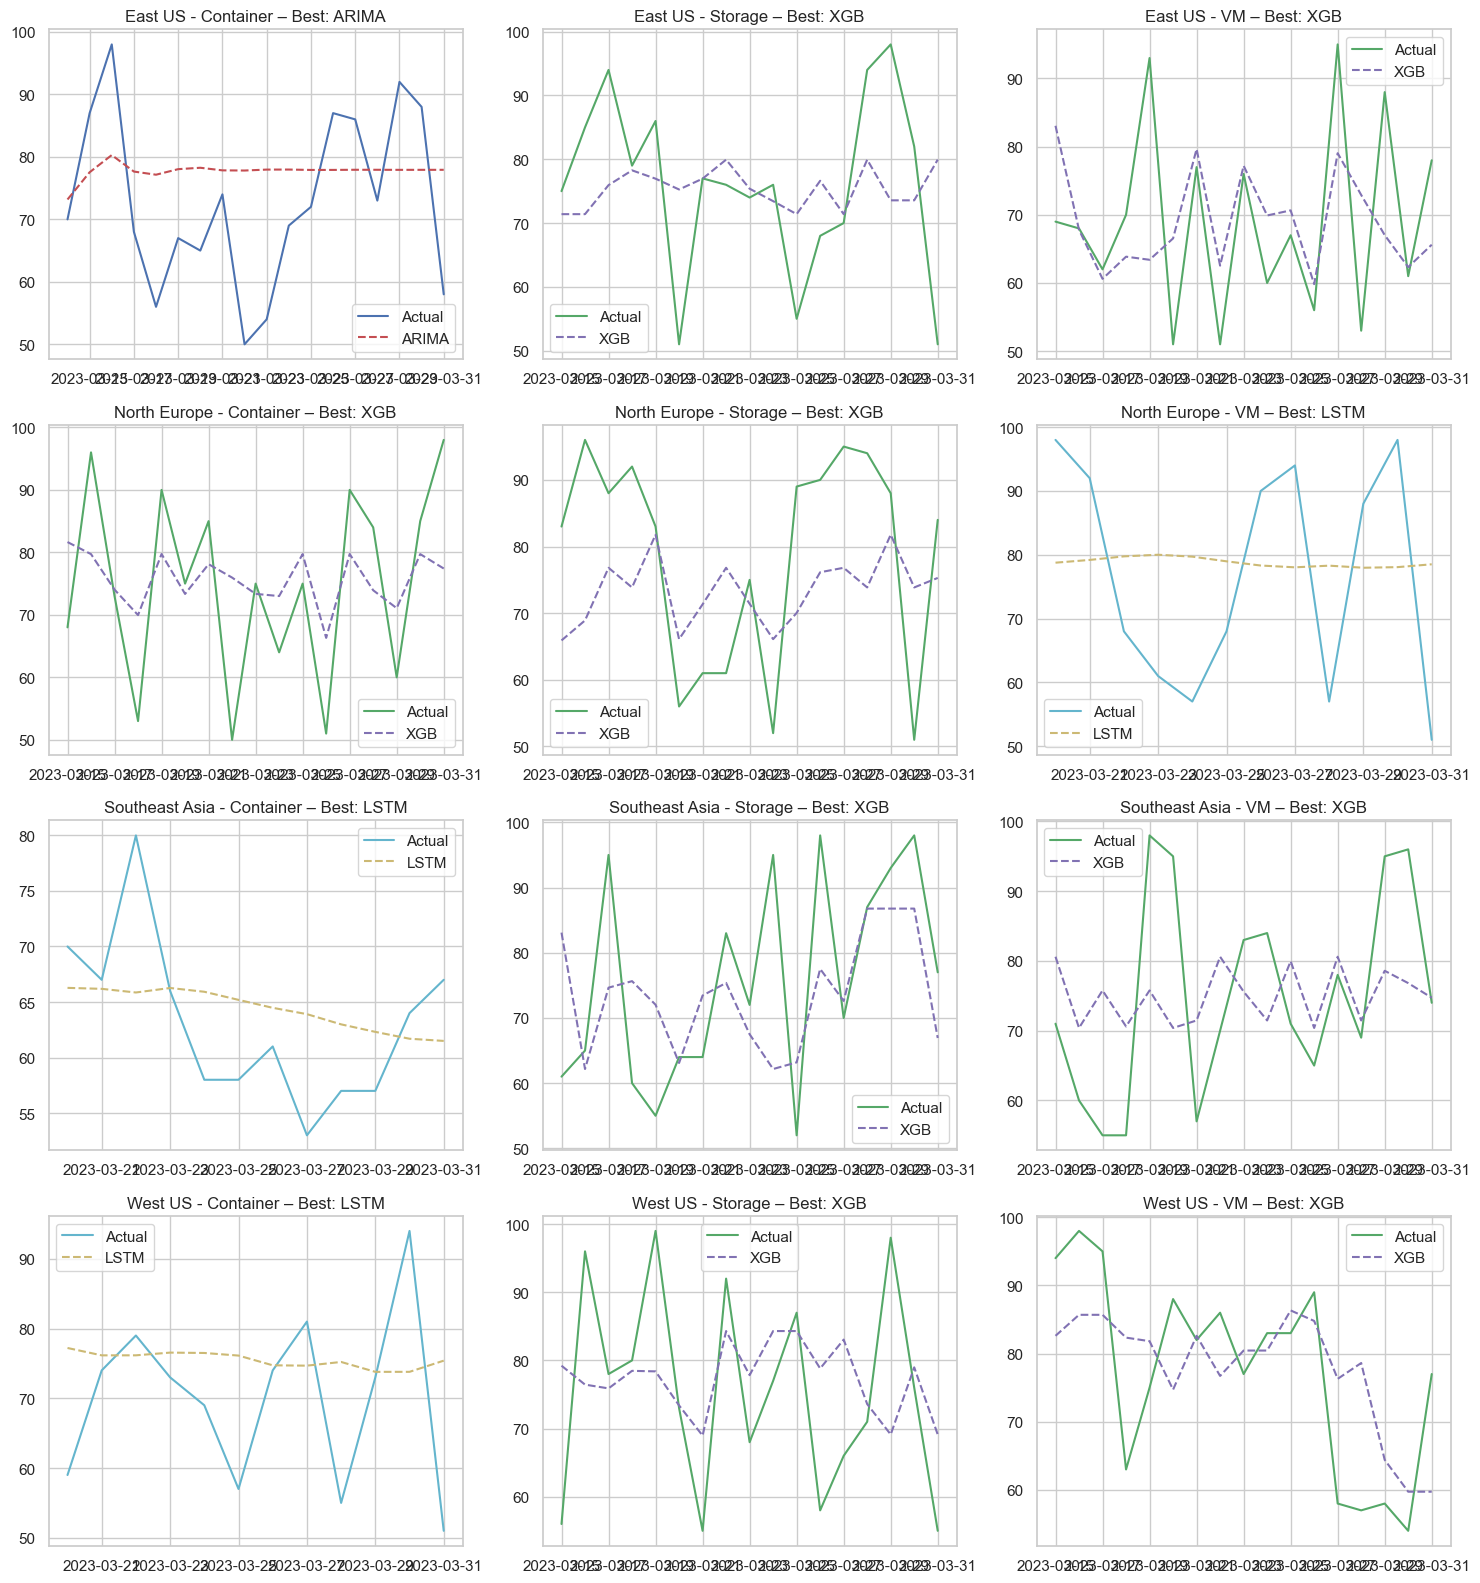


=== SUMMARY TABLE ===
                            ARIMA_RMSE  ARIMA_MAE  ARIMA_MAPE  XGB_RMSE  \
region_resource                                                           
East US - Container              14.14      12.34       18.69       NaN   
East US - Storage                  NaN        NaN         NaN     13.86   
East US - VM                       NaN        NaN         NaN     12.99   
North Europe - Container           NaN        NaN         NaN     12.58   
North Europe - Storage             NaN        NaN         NaN     15.49   
North Europe - VM                  NaN        NaN         NaN       NaN   
Southeast Asia - Container         NaN        NaN         NaN       NaN   
Southeast Asia - Storage           NaN        NaN         NaN     14.37   
Southeast Asia - VM                NaN        NaN         NaN     13.87   
West US - Container                NaN        NaN         NaN       NaN   
West US - Storage                  NaN        NaN         NaN     14.43   
We

In [8]:
# Cell 9 (updated for Approach 3): Compare & Visualize per (region, resource_type) with Summary Table

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare summary results list
results = []

# Compute how many plots per row/col dynamically based on number of combos
n_plots = len(region_resource_dfs)
cols = 3
rows = int(np.ceil(n_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten() if n_plots > 1 else [axes]

for i, ((region, resource_type), ts) in enumerate(region_resource_dfs.items()):
    ax = axes[i]
    
    # Get RMSE metrics for the three models
    arima_rmse = arima_results.get((region, resource_type), (None, np.nan))[1]
    xgb_rmse = xgb_results.get((region, resource_type), (None, np.nan))[1]
    lstm_rmse = lstm_results.get((region, resource_type), (None, np.nan))[2]
    
    metrics = {
        'ARIMA': arima_rmse,
        'XGB': xgb_rmse,
        'LSTM': lstm_rmse
    }
    
    # Select best model based on RMSE
    best_model = min(metrics, key=metrics.get)
    
    # Plot Actual vs Predicted for the best model
    if best_model == 'ARIMA' and (region, resource_type) in arima_results:
        model, _, _, _, test_ts, preds = arima_results[(region, resource_type)]
        ax.plot(test_ts.index, test_ts.values, 'b-', label='Actual')
        ax.plot(test_ts.index, preds.values, 'r--', label='ARIMA')
        arima_metrics = arima_results[(region, resource_type)][1:4]
    else:
        arima_metrics = (np.nan, np.nan, np.nan)
    
    if best_model == 'XGB' and (region, resource_type) in xgb_results:
        _, xgb_rmse, xgb_mae, xgb_mape, idx, y_test, preds = xgb_results[(region, resource_type)]
        ax.plot(idx, y_test, 'g-', label='Actual')
        ax.plot(idx, preds, 'm--', label='XGB')
    else:
        xgb_rmse, xgb_mae, xgb_mape = (np.nan, np.nan, np.nan)
        
    if best_model == 'LSTM' and (region, resource_type) in lstm_results:
        _, _, lstm_rmse, lstm_mae, lstm_mape, _, y_test, preds = lstm_results[(region, resource_type)]
        dates = ts.index[-len(y_test):]
        ax.plot(dates, y_test, 'c-', label='Actual')
        ax.plot(dates, preds, 'y--', label='LSTM')
    else:
        lstm_rmse, lstm_mae, lstm_mape = (np.nan, np.nan, np.nan)
    
    ax.set_title(f"{region} - {resource_type} – Best: {best_model}")
    ax.legend()
    
    # Append summary metrics for this combination
    results.append({
        'region_resource': f"{region} - {resource_type}",
        'ARIMA_RMSE': round(arima_metrics[0], 2) if not np.isnan(arima_metrics[0]) else np.nan,
        'ARIMA_MAE': round(arima_metrics[1], 2) if not np.isnan(arima_metrics[1]) else np.nan,
        'ARIMA_MAPE': round(arima_metrics[2], 2) if not np.isnan(arima_metrics[2]) else np.nan,
        'XGB_RMSE': round(xgb_rmse, 2) if not np.isnan(xgb_rmse) else np.nan,
        'XGB_MAE': round(xgb_mae, 2) if not np.isnan(xgb_mae) else np.nan,
        'XGB_MAPE': round(xgb_mape, 2) if not np.isnan(xgb_mape) else np.nan,
        'LSTM_RMSE': round(lstm_rmse, 2) if not np.isnan(lstm_rmse) else np.nan,
        'LSTM_MAE': round(lstm_mae, 2) if not np.isnan(lstm_mae) else np.nan,
        'LSTM_MAPE': round(lstm_mape, 2) if not np.isnan(lstm_mape) else np.nan
    })

# Remove empty subplots if any
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Create summary DataFrame with region-resource as index for clarity
results_df = pd.DataFrame(results).set_index('region_resource')
print("\n=== SUMMARY TABLE ===")
print(results_df)
